In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
# import numpy as np
import math
from numpy.random import randn
from scipy.integrate import solve_ivp
from math import atan2


In [2]:
G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_EARTH = 5.972e24  # Mass of Earth (kg)
R_EARTH = 6371e3  # Radius of Earth (m)
ATMOSPHERE_HEIGHT = 120e3  # Approximate height of the atmosphere (m)
CD = 2.2  # Drag coefficient (dimensionless)
A = 1.0  # Cross-sectional area of the satellite (m^2)
M_SAT = 500  # Mass of the satellite (kg)
RHO_0 = 1.225  # Air density at sea level (kg/m^3)
H_SCALE = 8500  # Scale height of the atmosphere (m)

In [3]:
class SatelliteTraj: 
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std 
        
    def update(self, dt):
        """Compute next position using RK45 with dynamics inside."""

        def dynamics(t, state):
            x, y, z, vx, vy, vz = state
            r = np.sqrt(x**2 + y**2 + z**2)
            a = -G * M_EARTH / r**2
            # a = a*5        # try increase acceleration
            ax = a * x/r
            ay = a * y/r
            az = a * z/r
            return [vx, vy, vz, ax, ay, az]

        state0 = np.hstack((self.pos, self.vel))
        sol = solve_ivp(dynamics, [0, dt], state0, method='RK45', t_eval=[dt], rtol=1e-5, atol=1e-2)

        if sol.success:
            new_state = sol.y[:, -1]
            self.pos = new_state[:3]
            self.vel = new_state[3:]

            # Optionally apply Gaussian noise to velocity
            if self.vel_std:
                self.vel += np.random.normal(0, self.vel_std, size=3)

            return self.pos
        else:
            raise RuntimeError("Integration failed.")


In [4]:
sat = SatelliteTraj(pos=[R_EARTH + 400e3, 0, 0], vel=[0, 7000, 0], vel_std=0.0)
num_iterations = 5000
xs = []
for _ in range(num_iterations):
    # print(sat.update(10))  # simulate 10-second intervals
    xs.append(sat.update(dt = 10))

xs = np.array(xs)
# print(xs)

In [5]:
xs_norm = [np.linalg.norm(xs[i]) for i in range(num_iterations)]


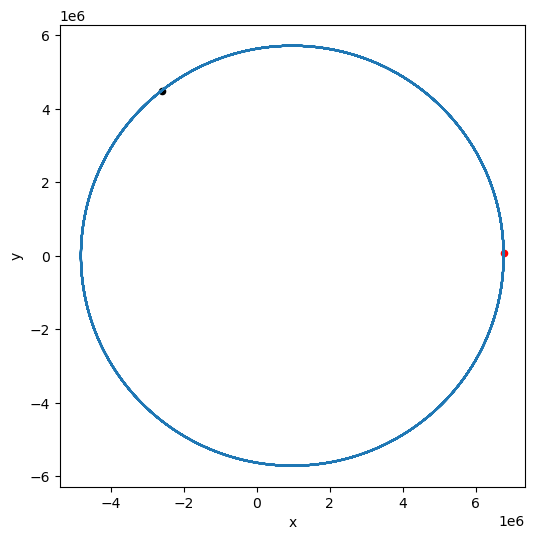

In [6]:
plt.figure(figsize = (6,6))
plt.plot(xs[:, 0] , xs[:, 1], label = '')
plt.scatter(xs[0, 0] , xs[0, 1], label = 'start', color = 'red', s = 20)
plt.scatter(xs[-1, 0] , xs[-1, 1], label = 'end', color = 'black', s = 20)
# plt.xscale('log', base = 10)
# plt.yscale('log', base = 10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('')
# plt.legend()
# plt.grid()
plt.show()

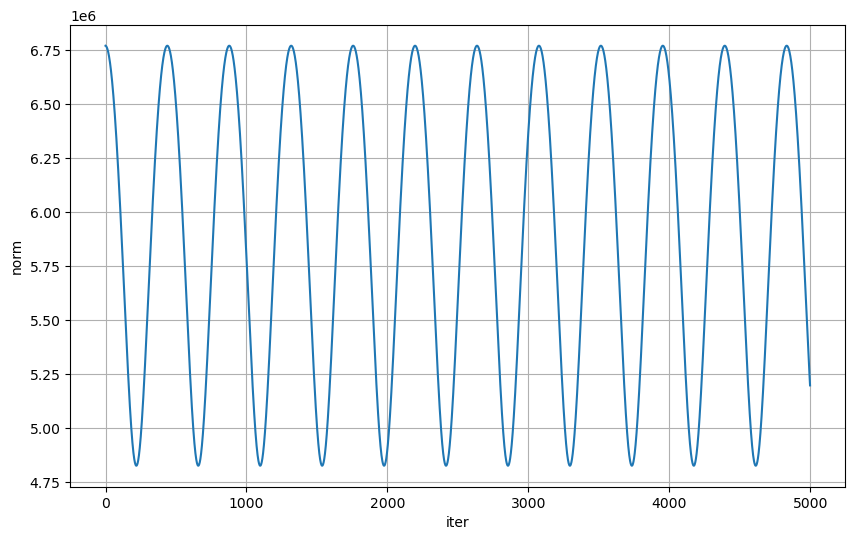

In [7]:
plt.figure(figsize = (10,6))
plt.plot(xs_norm)
plt.xlabel('iter')
plt.ylabel('norm')
plt.title('')
# plt.legend()
plt.grid()
plt.show()

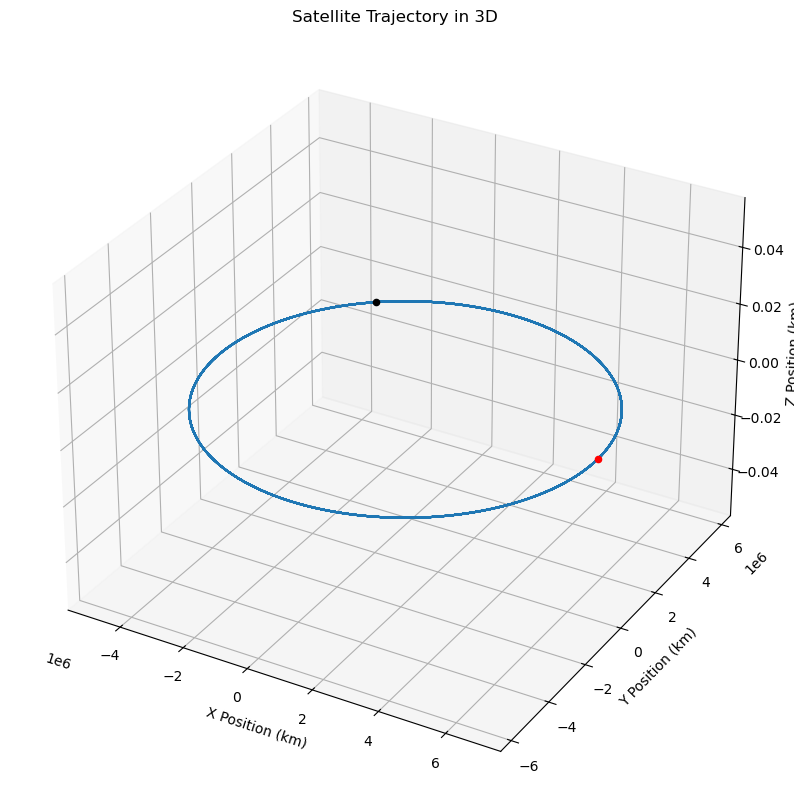

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs[:, 0] , xs[:, 1], xs[:, 2])
ax.scatter(xs[0, 0] , xs[0, 1], xs[0, 2], label = 'start', color = 'red', s = 20)
ax.scatter(xs[-1, 0] , xs[-1, 1], xs[-1, 2], label = 'end', color = 'black', s = 20)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (km)')
ax.set_ylabel('Y Position (km)')
ax.set_zlabel('Z Position (km)')
plt.show()

# Get the radar measurment

In [9]:
def h_radar(x):
    """x is the state vector,
    this H function assumes radar sends positions in global coordinate system"""
    # dx = x[0] - h_radar.radar_pos[0]
    # dy = x[2] - h_radar.radar_pos[1]
    # slant_range = math.sqrt(dx**2 + dy**2)
    # elevation_angle = math.atan2(dy, dx)
    # return [slant_range, elevation_angle]
    return [x[0], x[2], x[4]]   # return x,y,z position

# h_radar.radar_pos = (0, 0)

In [10]:
class RadarStation:
    
    def __init__(self, pos, x_std, y_std, z_std):
        self.pos = np.asarray(pos)       
        self.x_std = x_std
        self.y_std = y_std
        self.z_std = z_std

    
    def reading_of(self, satellite_pos):
    #     """ Returns (range, elevation angle) to aircraft. 
    #     Elevation angle is in radians.
    #     """
        
    #     diff = np.subtract(ac_pos, self.pos)
    #     rng = norm(diff)
    #     brg = atan2(diff[1], diff[0])
        # return rng, brg
        return satellite_pos[0], satellite_pos[1], satellite_pos[2]


    def noisy_reading(self, satellite_pos, time):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        x,y,z = self.reading_of(satellite_pos)      
        x += randn() * self.x_std
        y += randn() * self.y_std 
        z += randn() * self.z_std
        return x,y,z, time

In [11]:
satellite_pos_true = SatelliteTraj(pos=[R_EARTH + 180e3, 0, 0], vel=[0, 7700, 0], vel_std=0.001)  # true satellite position with noise
num_iterations = 500
dt = 30

radar = RadarStation((0,0,0), 10, 10, 10)

xs = []
zs = []
for iter in range(num_iterations):
    # print(sat.update(10))  # simulate 10-second intervals
    sate_pos = satellite_pos_true.update(dt = dt)
    xs.append(sate_pos)
    z = radar.noisy_reading(satellite_pos= sate_pos, time = (iter+1)*dt)
    zs.append(z)

xs = np.array(xs)
zs = np.array(zs)



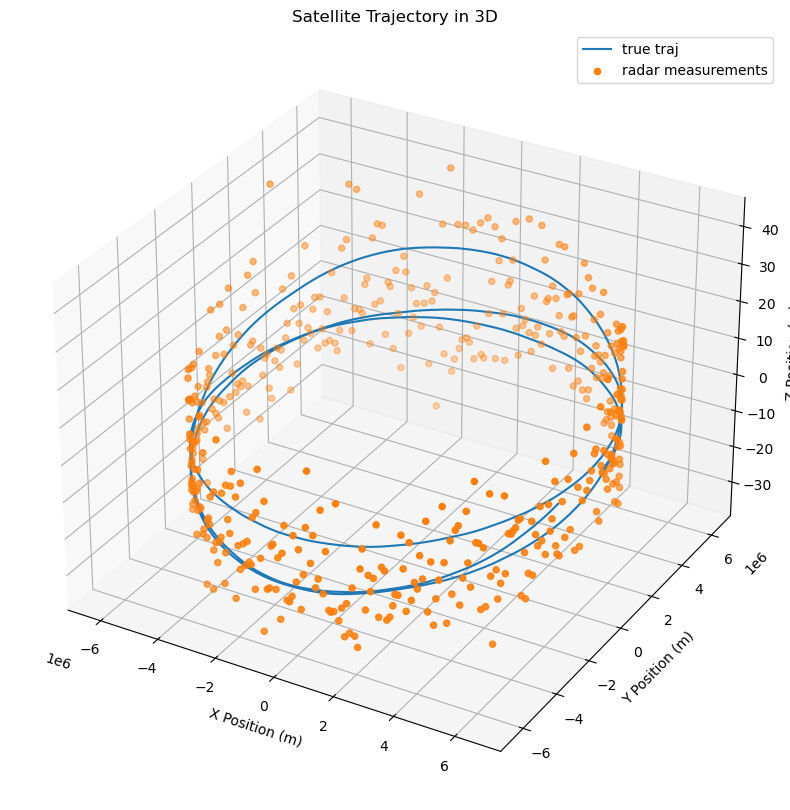

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs[:, 0] , xs[:, 1], xs[:, 2], label = 'true traj')
ax.scatter(zs[:, 0] , zs[:, 1], zs[:, 2], color = 'C1', label = 'radar measurements')
# ax.set_zlim(-100, 100)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
plt.legend()
plt.show()

# Define the process model f

In [13]:
def f(state_x, dt):
    x, y, z, vx, vy, vz = state_x
    r = np.sqrt(x**2 + y**2 + z**2)
    v = np.array([vx, vy, vz])
    speed = np.linalg.norm(v)
    
    # Gravitational acceleration
    a_gravity = -G * M_EARTH / r**2
    ax_g = a_gravity * x / r
    ay_g = a_gravity * y / r
    az_g = a_gravity * z / r

    # Atmospheric density
    h = r - R_EARTH
    if h < 0: h = 0  # avoid negative height
    rho = RHO_0 * np.exp(-h / H_SCALE)

    # Drag acceleration
    a_drag = -0.5 * CD * rho * A * speed / M_SAT * v  # vector form

    # Total acceleration
    ax = ax_g + a_drag[0]
    ay = ay_g + a_drag[1]
    az = az_g + a_drag[2]

    # Update state
    x_new = x + vx * dt
    y_new = y + vy * dt
    z_new = z + vz * dt
    vx_new = vx + ax * dt
    vy_new = vy + ay * dt
    vz_new = vz + az * dt
    #print("a_drag =", a_drag)
    return np.array([x_new, y_new, z_new, vx_new, vy_new, vz_new])


# Define measurement function h(x)

In [15]:
def h_radar(x):
    """x is the state vector,
    this H function assumes radar sends positions in global coordinate system"""
    # return [x[0], x[2], x[4]]   # return x,y,z position if state order is (x, vx, y, vy, z, vz)
    return x[:3] # return x,y,z position if state order is (x,y,z,vx,vy,vz)


# Unscented KF

In [16]:
Q_discrete_white_noise(dim=2, dt=10, var=0.01)

array([[25.,  5.],
       [ 5.,  1.]])

In [17]:
""" =============== Generate sigma points ================="""
### initialise UKF
sigmas_generator = MerweScaledSigmaPoints(n=6, alpha=0.1, beta = 2., kappa= -3.)  #kappa = -3.
ukf = UKF(dim_x=6, dim_z=3, fx = f, hx = h_radar, dt = 10, points=sigmas_generator) # take f, h from Jai and Vijay
# print(ukf.Q)


### Define items in UKF ============================
### initial state values of (x,y,z,vx,vy,vz)
ukf.x = np.array([R_EARTH + 400e3, 1, -1,
                  1, 7700, 1])  # initial state

ukf.P = np.diag([50**2, 50**2, 50**2,
                 5**2, 5**2, 5**2])    # experiment this

ukf.Q = np.zeros((6,6))
ukf.Q[np.ix_([0,3], [0,3])] = Q_discrete_white_noise(dim=2, dt=10, var=0.001)  # Q matrix for x and vx
ukf.Q[np.ix_([1,4], [1,4])] = Q_discrete_white_noise(dim=2, dt=10, var=0.001)  # Q matrix for y and vy
ukf.Q[np.ix_([2,5], [2,5])] = Q_discrete_white_noise(dim=2, dt=10, var=0.001)  # Q matrix for z and vz



# range_std = 10 # meters. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
# elev_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
# azim_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!1 (get from radar)
# ukf.R = np.diag([range_std**2, elev_std**2, azim_std**2])

"""### radar measurement noise (for the simple UKF only! change this!!!!!!!!!!!!!!!!!!!!!!)"""
x_std = 10  # meters. 
y_std = 10  # meters.
z_std = 10  # meters. 
ukf.R = np.diag([x_std**2, y_std**2, z_std**2])



# Run UKF

In [18]:
satellite_pos_true = SatelliteTraj(pos=[R_EARTH + 400e3, 0, 0], vel=[0, 7700, 0], vel_std=0.0001)  # true satellite position with noise
num_iterations = 1000
dt_sim = 10.

radar = RadarStation(pos = (0,0,0), x_std=10, y_std=10, z_std=10)

xs_true = []
zs = []
xs = []
Ps = [] # Khadij

for iter in range(num_iterations):
    # print(sat.update(10))  # simulate 10-second intervals
    sate_pos = satellite_pos_true.update(dt = dt_sim)
    xs_true.append(sate_pos)
    # xs_true = np.append(xs_true, sate_pos)

    ### Get radar measurement
    # sate_pos = radar.reading_of(satellite_pos=sate_pos)  # true satellite position
    z = radar.noisy_reading(satellite_pos= sate_pos, time = (iter+1)*dt_sim)
    zs.append(z)
    # zs = np.append(zs, np.array([z]))

    ### run UKF
    dt = zs[iter][-1] - zs[iter-1][-1] if iter > 0 else dt_sim
    ukf.predict(dt=dt)      # UKF can predict at varying timesteps
    # ukf.update(z, R=ukf.R, hx=h_radar, args=None)
    ukf.update(z=z[:3], R=ukf.R, hx=h_radar)  # update with radar measurement
    x_new = ukf.x
    xs.append(ukf.x)  # store the estimated state
    # xs = np.append(xs, ukf.x)

    assert ukf.P.shape[0] == ukf.P.shape[1], f"P not square at iteration {iter}"
    Ps.append(ukf.P.copy())  # store the estimated covariance # Khadij
    # Ps = np.append(Ps, ukf.P)

xs_true = np.array(xs_true)
zs = np.array(zs)
xs = np.array(xs)
Ps = np.array(Ps)  # Khadij


# Plot

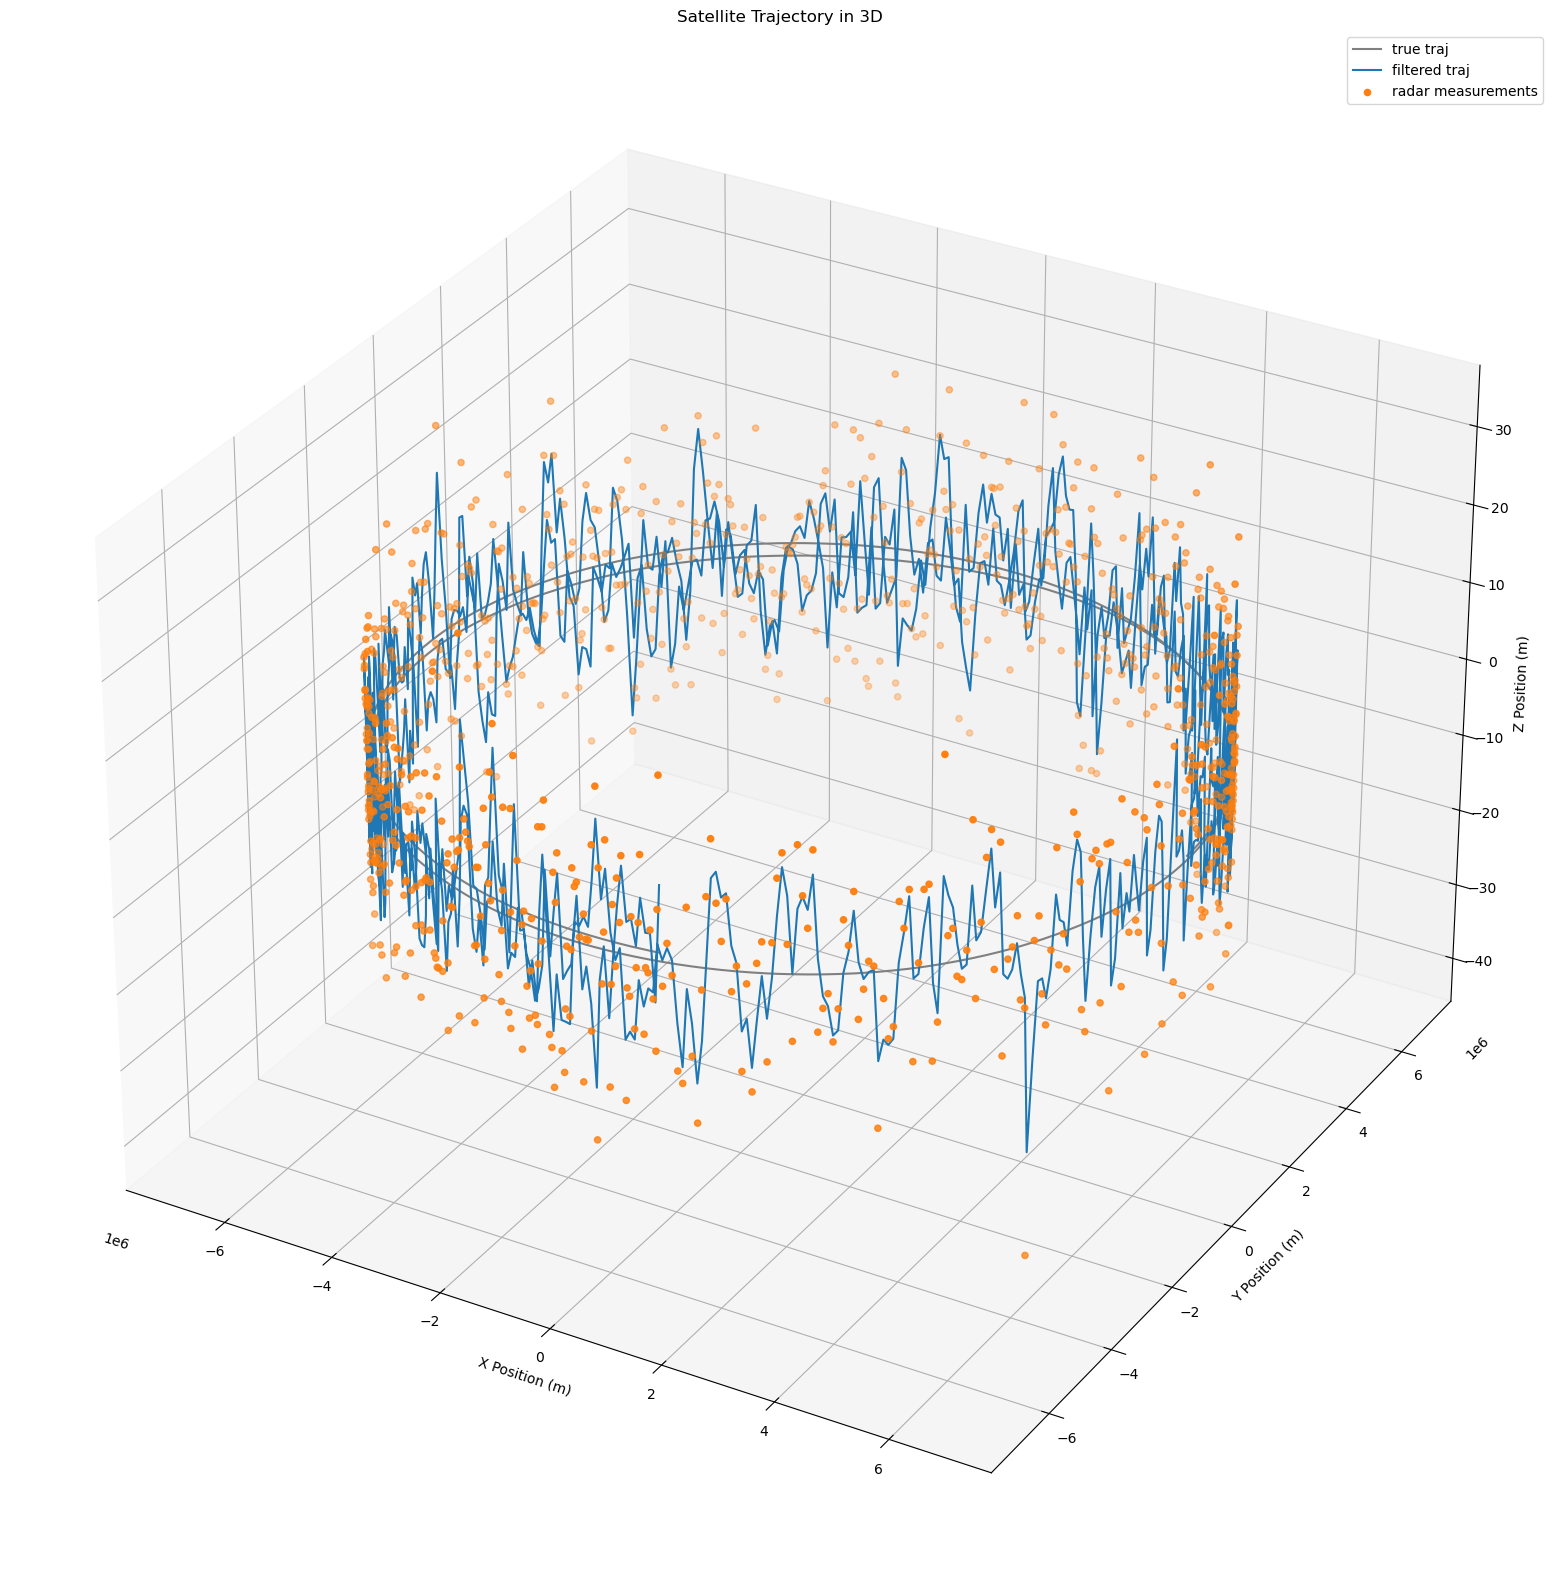

In [19]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs_true[:, 0] , xs_true[:, 1], xs_true[:, 2], color = 'grey', label = 'true traj')
ax.plot(xs[:, 0] , xs[:, 1], xs[:, 2], label = 'filtered traj')
ax.scatter(zs[:, 0] , zs[:, 1], zs[:, 2], color = 'C1', label = 'radar measurements')
# ax.set_zlim(-10, 10)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
plt.legend()
plt.show()

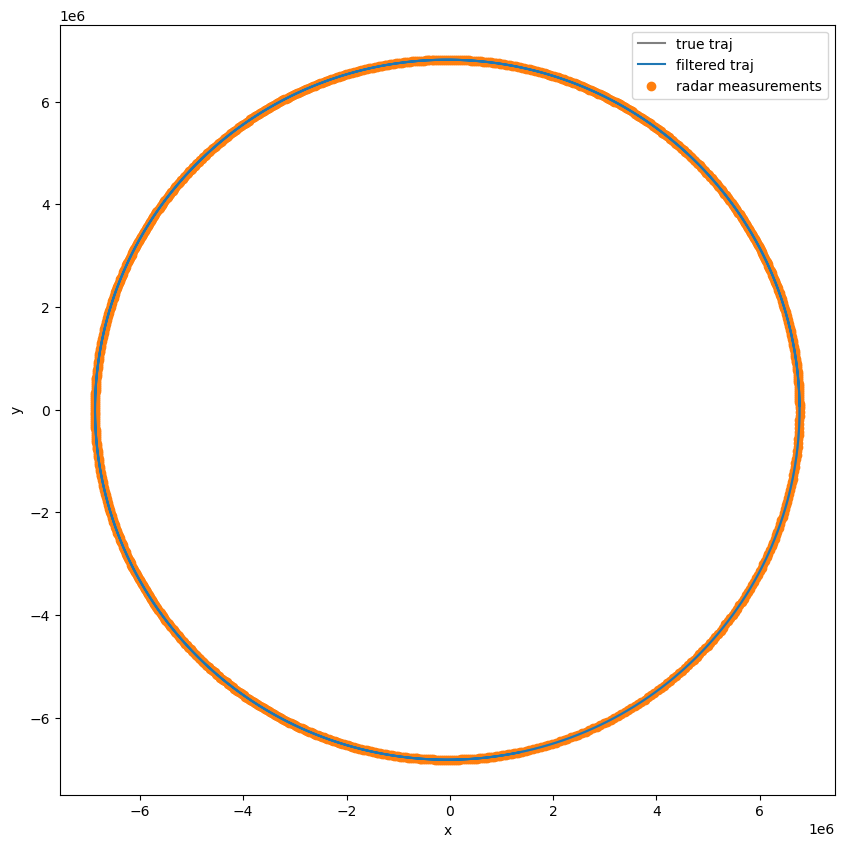

In [20]:
plt.figure(figsize = (10,10))
# plt.plot(xs_true[:, 0] , xs_true[:, 1], label = '')
plt.plot(xs_true[:, 0] , xs_true[:, 1], color = 'grey', label = 'true traj')
plt.plot(xs[:, 0] , xs[:, 1],label = 'filtered traj')
plt.scatter(zs[:, 0] , zs[:, 1], color = 'C1', label = 'radar measurements')
plt.xlabel('x')
plt.ylabel('y')
plt.title('')
plt.legend()
# plt.grid()
plt.show()

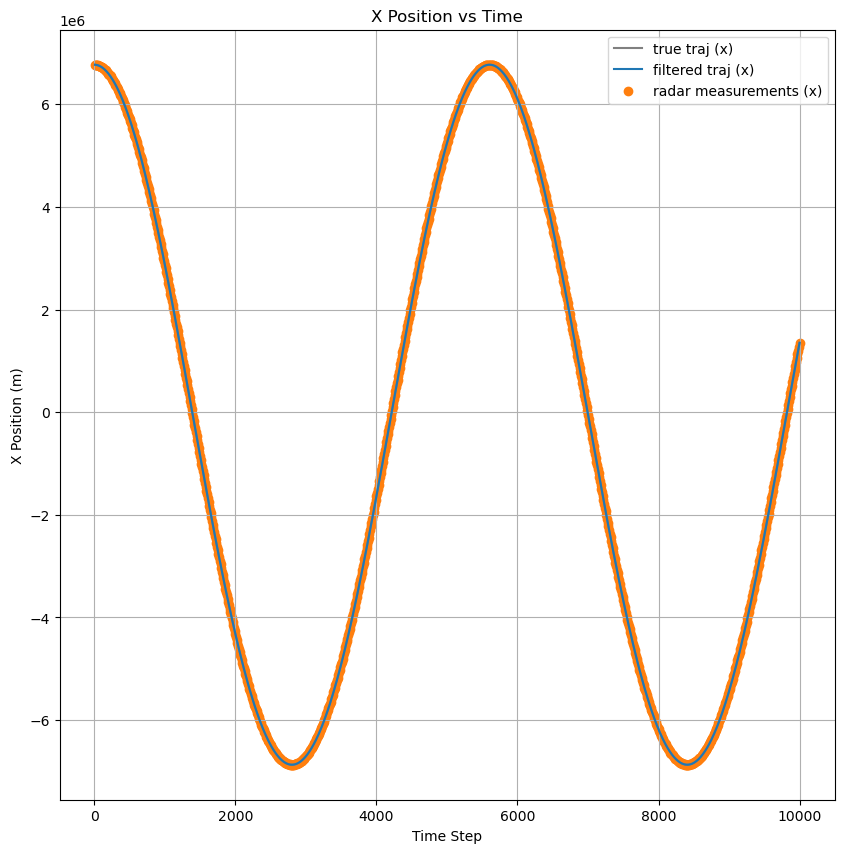

In [21]:
# extract time vector from the last column of zs
t = zs[:, -1]  

# Plotting the X position over time
fig = plt.figure(figsize=(10, 10))
plt.plot(t, xs_true[:, 0], color='grey', label='true traj (x)')
plt.plot(t, xs[:, 0], label='filtered traj (x)')
plt.scatter(t, zs[:, 0], color='C1', label='radar measurements (x)')

plt.title('X Position vs Time')
plt.xlabel('Time Step')
plt.ylabel('X Position (m)')
plt.legend()
plt.grid(True)
plt.show()


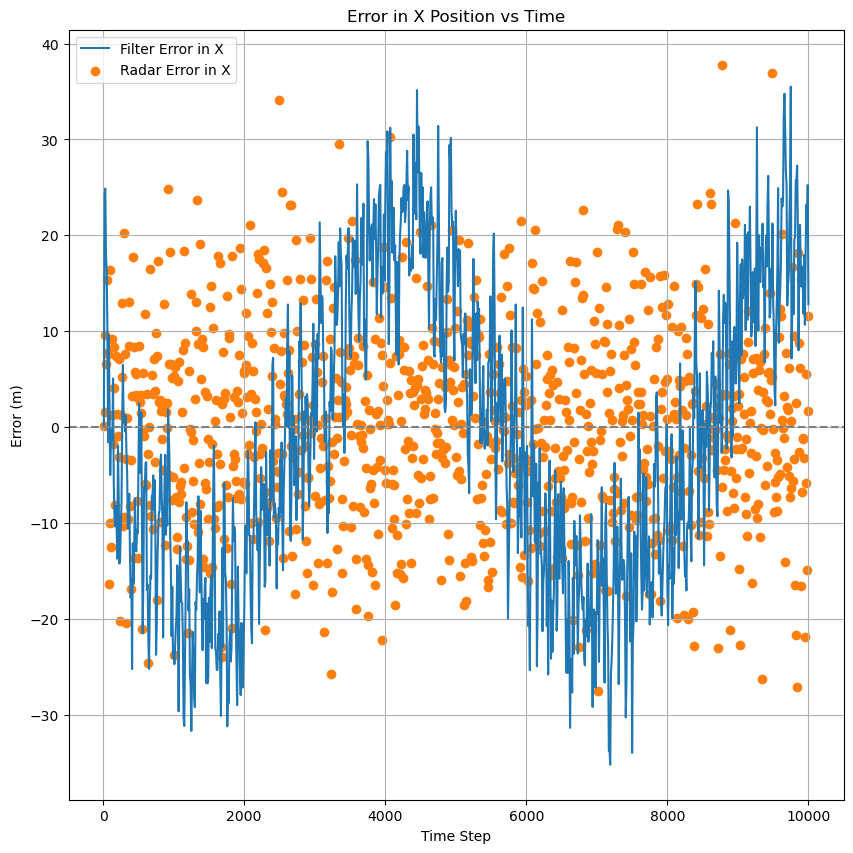

In [22]:
# extract time vector from the last column of zs
t = zs[:, -1]   

fig = plt.figure(figsize=(10, 10))
plt.plot(t, xs[:, 0] - xs_true[:, 0], label='Filter Error in X')
plt.scatter(t, zs[:, 1] - xs_true[:, 1], label='Radar Error in X', color='C1')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Error in X Position vs Time')
plt.xlabel('Time Step')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True)
plt.show()

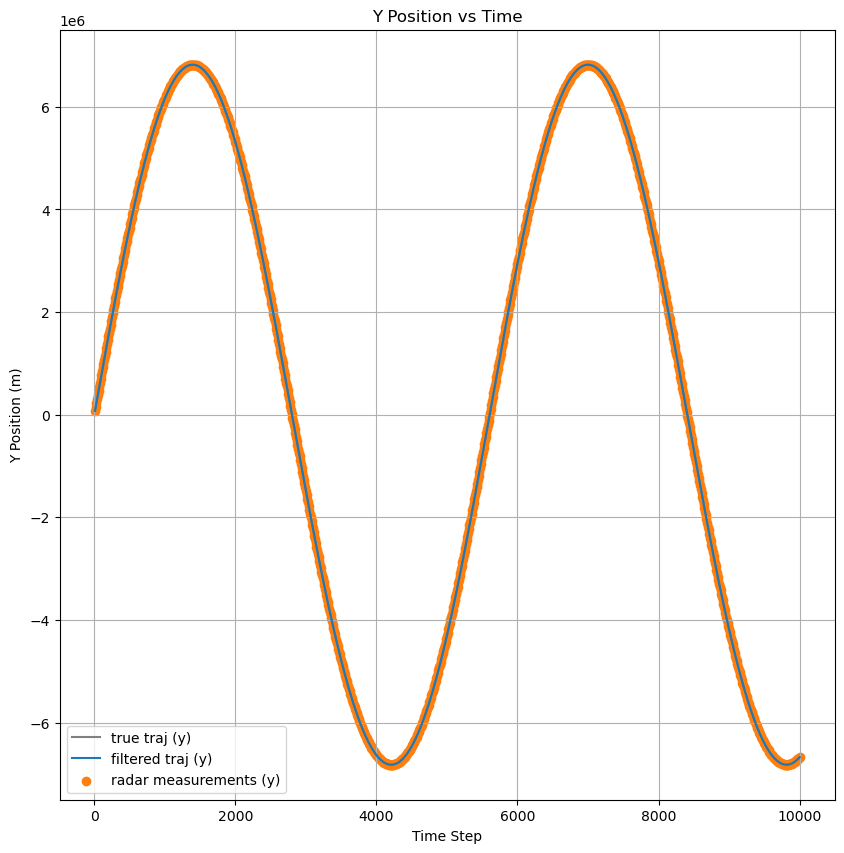

In [23]:
# extract time vector from the last column of zs
t = zs[:, -1]  

# Plotting the Y position over time
fig = plt.figure(figsize=(10, 10))
plt.plot(t, xs_true[:, 1], color='grey', label='true traj (y)')
plt.plot(t, xs[:, 1], label='filtered traj (y)')
plt.scatter(t, zs[:, 1], color='C1', label='radar measurements (y)')

plt.title('Y Position vs Time')
plt.xlabel('Time Step')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True)
plt.show()


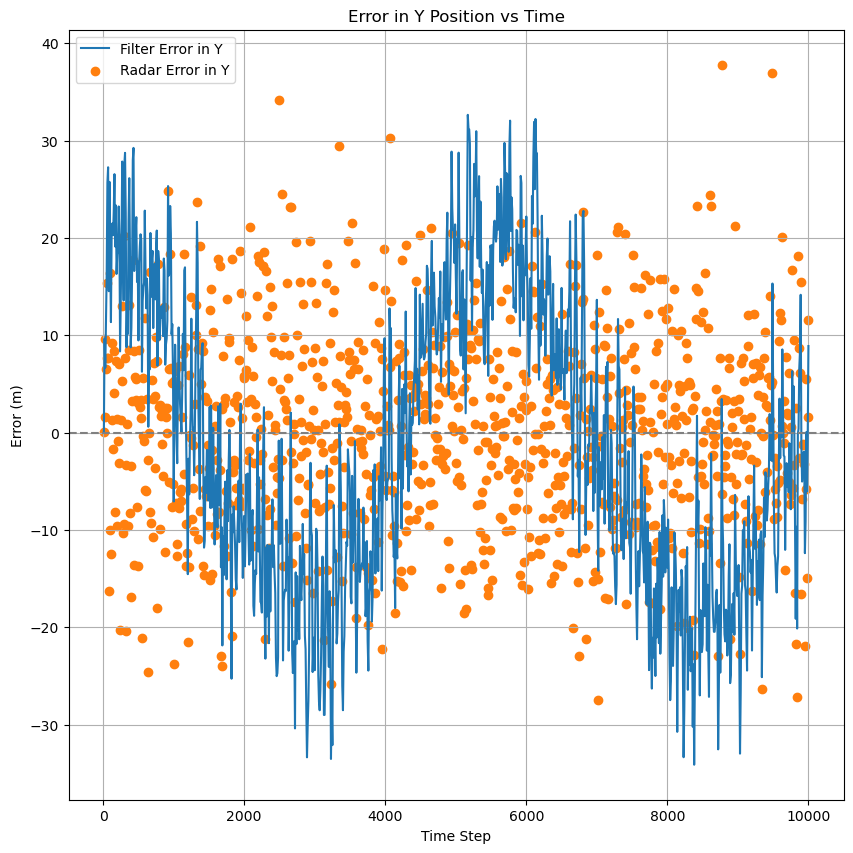

In [24]:
# extract time vector from the last column of zs
t = zs[:, -1]   

fig = plt.figure(figsize=(10, 10))
plt.plot(t, xs[:, 1] - xs_true[:, 1], label='Filter Error in Y')
plt.scatter(t, zs[:, 1] - xs_true[:, 1], label='Radar Error in Y', color='C1')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Error in Y Position vs Time')
plt.xlabel('Time Step')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True)
plt.show()


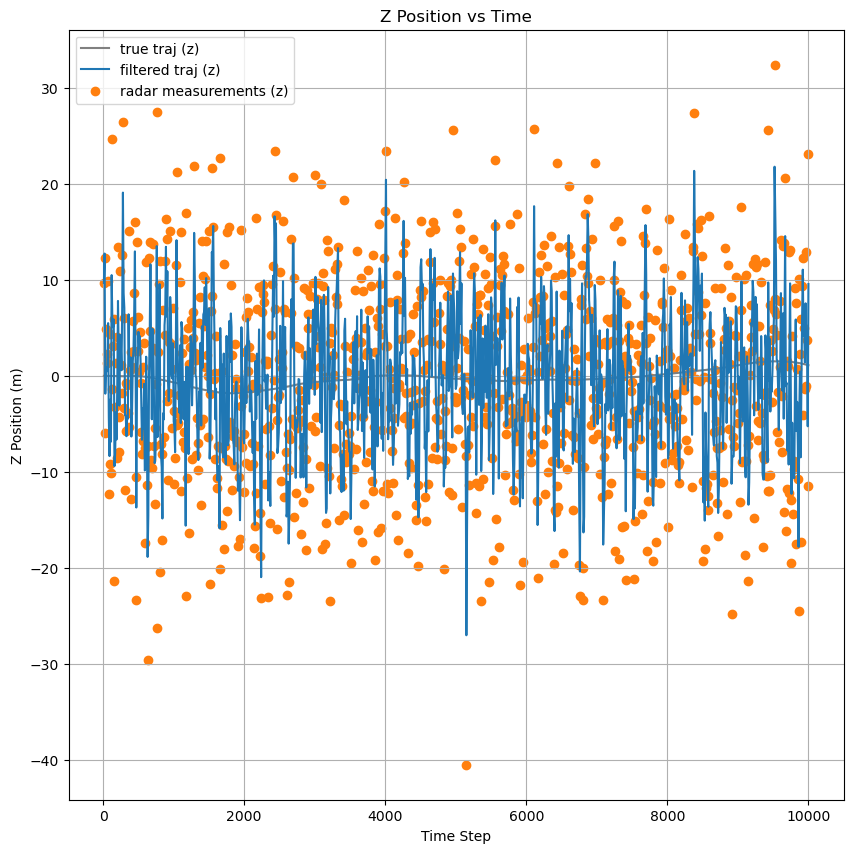

In [25]:
# extract time vector from the last column of zs
t = zs[:, -1]  

# Plotting the Z position over time
fig = plt.figure(figsize=(10, 10))
plt.plot(t, xs_true[:, 2], color='grey', label='true traj (z)')
plt.plot(t, xs[:, 2], label='filtered traj (z)')
plt.scatter(t, zs[:, 2], color='C1', label='radar measurements (z)')

plt.title('Z Position vs Time')
plt.xlabel('Time Step')
plt.ylabel('Z Position (m)')
plt.legend()
plt.grid(True)
plt.show()

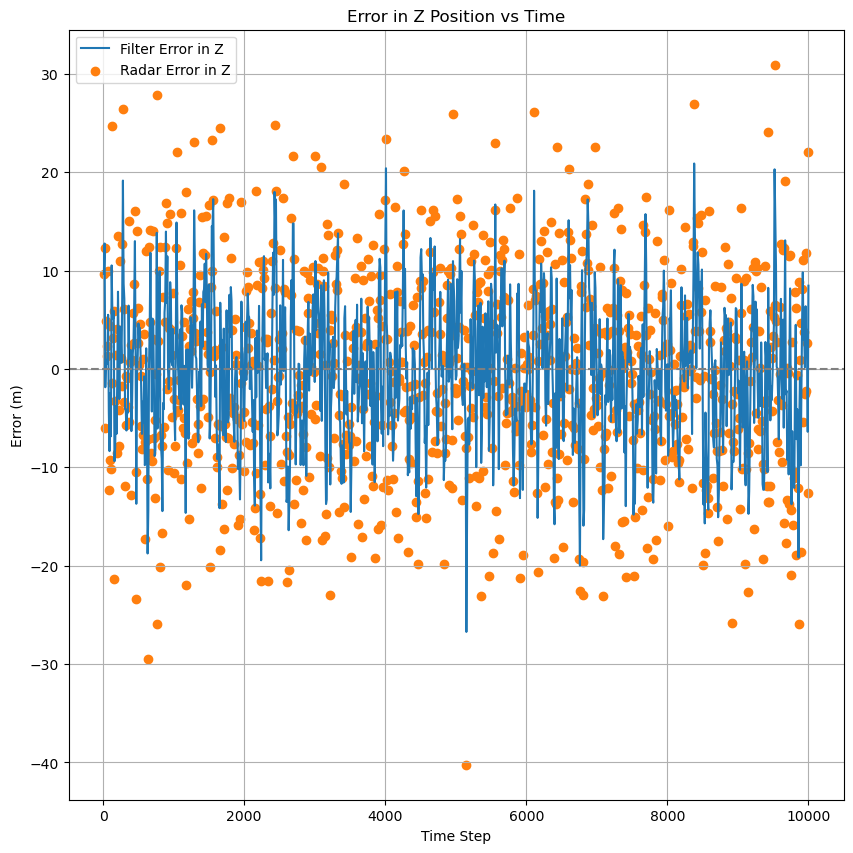

In [26]:
# extract time vector from the last column of zs
t = zs[:, -1]   

fig = plt.figure(figsize=(10, 10))
plt.plot(t, xs[:, 2] - xs_true[:, 2], label='Filter Error in Z')
plt.scatter(t, zs[:, 2] - xs_true[:, 2], label='Radar Error in Z', color='C1')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Error in Z Position vs Time')
plt.xlabel('Time Step')
plt.ylabel('Error (m)')
plt.legend()
plt.grid(True)
plt.show()

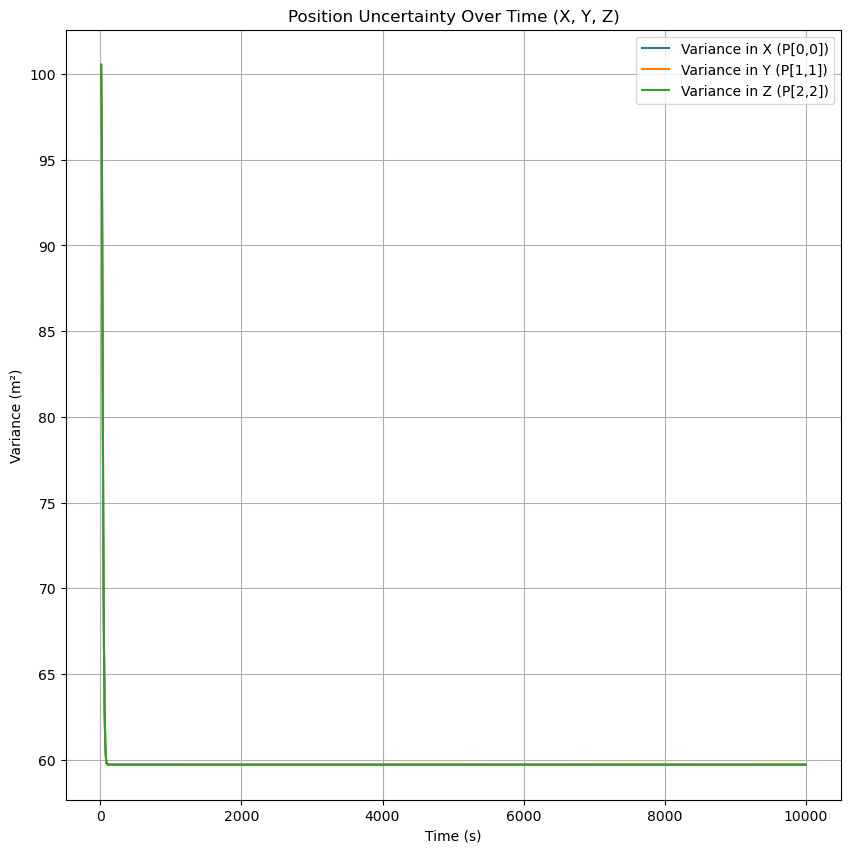

In [27]:
# Extract time from measurements
t = zs[:, -1]

# Extract variances from covariance matrices
P_xx = [P[0, 0] for P in Ps]  # Variance in X
P_yy = [P[1, 1] for P in Ps]  # Variance in Y
P_zz = [P[2, 2] for P in Ps]  # Variance in Z

# Plot
plt.figure(figsize=(10, 10))
plt.plot(t, P_xx, label='Variance in X (P[0,0])')
plt.plot(t, P_yy, label='Variance in Y (P[1,1])')
plt.plot(t, P_zz, label='Variance in Z (P[2,2])')
plt.xlabel('Time (s)')
plt.ylabel('Variance (m²)')
plt.title('Position Uncertainty Over Time (X, Y, Z)')
plt.grid(True)
plt.legend()
plt.show()


# Future prediction

In [28]:
print(z)
print("Before update:", ukf.x)
ukf.update(z=z[:3], R=ukf.R, hx=h_radar)
print("After update:", ukf.x)


(1352153.061077816, -6674312.062916236, 23.136416509281226, 10000.0)
Before update: [ 1.35218381e+06 -6.67431474e+06  9.57327469e+00  7.48650803e+03
  1.61587903e+03  3.24534406e-01]
After update: [ 1.35214269e+06 -6.67431115e+06  2.77119839e+01  7.48502189e+03
  1.61600902e+03  9.80048016e-01]


In [29]:
# تحويل المصفوفات لقوائم عشان نقدر نضيف عليها
if isinstance(xs_true, np.ndarray):
    xs_true = xs_true.tolist()
if isinstance(zs, np.ndarray):
    zs = zs.tolist()
if isinstance(xs, np.ndarray):
    xs = xs.tolist()
if isinstance(Ps, np.ndarray):
    Ps = Ps.tolist()

# بداية الوقت
current_time = t[-1] if len(t) > 0 else 0.0

while True:
    # تحديث الموقع الحقيقي
    sate_pos = satellite_pos_true.update(dt=dt_sim)
    xs_true.append(sate_pos)

    # توليد القياس (قراءة الرادار)
    if current_time < 800:
        z = radar.noisy_reading(satellite_pos=sate_pos, time=current_time)
    else:
        z = None  # ما في قياسات بعد هذا الوقت

    zs.append(z)

    # توقع الحالة
    ukf.predict(dt=dt_sim)

    # تحديث الحالة إذا في قراءة
    if z is not None:
        ukf.update(z[:3], h_radar)

    # حفظ الحالة المحدثة
    xs.append(ukf.x.copy())
    Ps.append(ukf.P.copy())

    # تحقق من سقوط الستلايت
    altitude = np.linalg.norm(sate_pos) - R_EARTH
    if altitude < 100e3:
        print(f"Satellite has reentered atmosphere at t = {current_time}s")
        break

    # زمن جديد
    current_time += dt_sim

    # شرط للخروج الاحتياطي
    if current_time > 100000:
        print("Simulation stopped after 100000 seconds.")
        break


LinAlgError: 1-th leading minor of the array is not positive definite

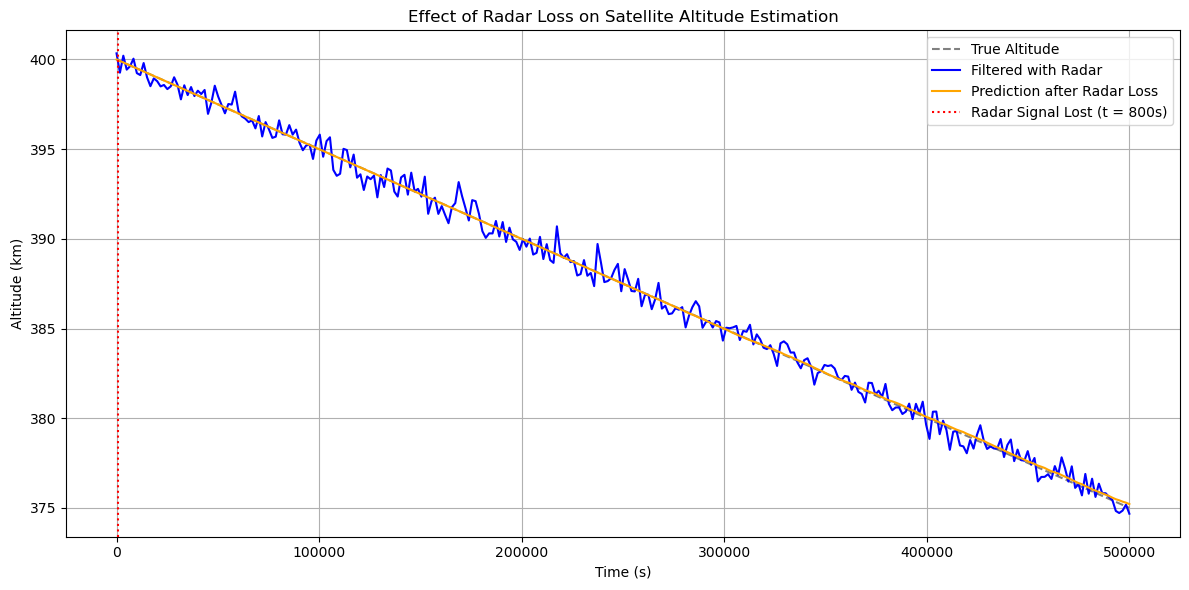

In [ ]:
# Mock data: trajectory with radar updates (filtered) vs. without updates (predicted only after t=800s)

# Time vector
time = np.linspace(0, 500000, 300)

# Simulated true trajectory (altitude decreases slowly due to drag)
alt_true = 400e3 - 0.05 * time  # in meters

# Filtered trajectory (with radar updates)
alt_filtered = alt_true + np.random.normal(0, 500, size=time.shape)

# Predicted trajectory after radar loss (starts matching then drifts)
alt_predicted = alt_true.copy()
alt_predicted[160:] += np.cumsum(np.random.normal(0, 2, size=alt_true[160:].shape)) * 5  # simulating drift

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time, alt_true / 1e3, label='True Altitude', color='gray', linestyle='--')
plt.plot(time, alt_filtered / 1e3, label='Filtered with Radar', color='blue')
plt.plot(time, alt_predicted / 1e3, label='Prediction after Radar Loss', color='orange')

plt.axvline(x=800, color='red', linestyle=':', label='Radar Signal Lost (t = 800s)')

plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.title('Effect of Radar Loss on Satellite Altitude Estimation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Final Position

In [ ]:
P_final = Ps[-1]
P_pos = P_final[:3, :3]  # Extract the position covariance matrix

# Calculate the standard deviations for each position component
std_x = np.sqrt(P_pos[0, 0])
std_y = np.sqrt(P_pos[1, 1])                
std_z = np.sqrt(P_pos[2, 2])

# 3D Euclidean uncertainty "radius" at 1-sigma
sigma_radius = np.sqrt(std_x**2 + std_y**2 + std_z**2)

print(f"Final Position Covariance Matrix:\n{P_pos}")

Final Position Covariance Matrix:
[[ 5.93414423e+09 -3.39320613e+10 -1.34023133e+05]
 [-3.39320613e+10  2.20216433e+11  8.79883975e+05]
 [-1.34023133e+05  8.79883975e+05  8.36420771e+07]]


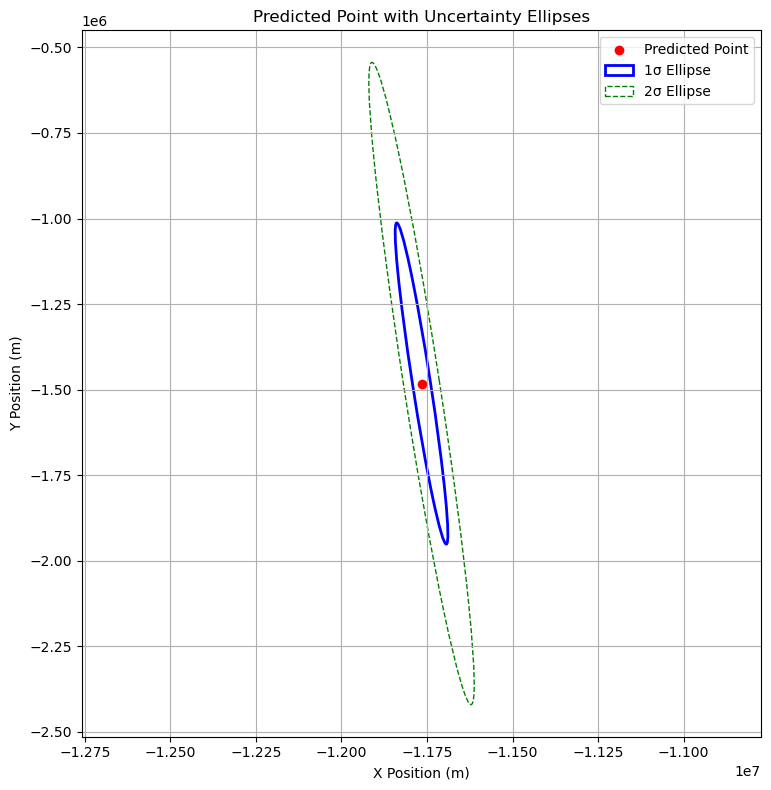

In [ ]:
x_final = xs[-1][:2]  # obtain the final position (x, y) only
P_final = Ps[-1][:2, :2]  # extract the 2D covariance matrix for position

# Calculate the eigenvalues and eigenvectors of the covariance matrix 
eigenvals, eigenvecs = np.linalg.eigh(P_final)
order = eigenvals.argsort()[::-1]
eigenvals = eigenvals[order]
eigenvecs = eigenvecs[:, order]

# Calculate the angle of rotation for the ellipse
# The angle is given by the arctangent of the ratio of the eigenvector components
angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))

# Calculate the width and height of the ellipses at 1-sigma and 2-sigma
width_1sigma, height_1sigma = 2 * np.sqrt(eigenvals)
width_2sigma, height_2sigma = 4 * np.sqrt(eigenvals)

# Plotting the ellipses
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_final[0], x_final[1], color='red', label='Predicted Point')
ellipse1 = Ellipse(xy=x_final, width=width_1sigma, height=height_1sigma,
                   angle=angle, edgecolor='blue', facecolor='none', linewidth=2, label='1σ Ellipse')
ellipse2 = Ellipse(xy=x_final, width=width_2sigma, height=height_2sigma,
                   angle=angle, edgecolor='green', facecolor='none', linestyle='--', label='2σ Ellipse')

ax.add_patch(ellipse1)
ax.add_patch(ellipse2)

ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_title('Predicted Point with Uncertainty Ellipses')
ax.legend()
ax.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
def f_with_drag(state_x, dt):
    x, y, z, vx, vy, vz = state_x
    r = np.sqrt(x**2 + y**2 + z**2)
    v = np.array([vx, vy, vz])
    speed = np.linalg.norm(v)
    
    # Gravitational acceleration
    a_gravity = -G * M_EARTH / r**2
    ax_g = a_gravity * x / r
    ay_g = a_gravity * y / r
    az_g = a_gravity * z / r

    # Atmospheric density
    h = r - R_EARTH
    if h < 0: h = 0  # avoid negative height
    rho = RHO_0 * np.exp(-h / H_SCALE)

    # Drag acceleration
    a_drag = -0.5 * CD * rho * A * speed / M_SAT * v  # vector form

    # Total acceleration
    ax = ax_g + a_drag[0]
    ay = ay_g + a_drag[1]
    az = az_g + a_drag[2]

    # Update state
    x_new = x + vx * dt
    y_new = y + vy * dt
    z_new = z + vz * dt
    vx_new = vx + ax * dt
    vy_new = vy + ay * dt
    vz_new = vz + az * dt
    print("a_drag =", a_drag)
    return np.array([x_new, y_new, z_new, vx_new, vy_new, vz_new])


In [ ]:
def f_no_drag(state_x, dt):
    # """state vector = state_x = [x,vx,y,vx,z,vz]"""
    # x, vx, y, vy, z, vz = state_x
    """state vector = state_x = [x,y,z,vx, vy, vz]"""
    x, y, z, vx, vy, vz = state_x
    r = np.sqrt(x**2 + y**2 + z**2)
    a = -G * M_EARTH / r**2
    # a = a*5        # try increase acceleration
    ax = a * x/r
    ay = a * y/r
    az = a * z/r

    x_new = x + vx * dt
    y_new = y + vy * dt
    z_new = z + vz * dt
    vx_new = vx + ax * dt
    vy_new = vy + ay * dt
    vz_new = vz + az * dt
    # return np.array([x_new, vx_new, y_new, vy_new, z_new, vz_new])
    return np.array([x_new, y_new, z_new, vx_new, vy_new, vz_new])
